## ランダムウォーク

### 参考サイト
>https://qiita.com/deaikei/items/00a2716ecc3e944c139a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%pylab inline --no-import-all

sns.set_context('poster')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def random_walker(start_position=0, mean=0, deviation=1, n_steps=99, seed=None):

    if seed is not None:
        np.random.seed(seed=seed)

    move = np.random.normal(loc=mean, scale=deviation, size=n_steps)
    position = np.insert(move, 0, start_position)
    position = np.cumsum(position)

    return position



def add_noise(position, mean=0, deviation=10, seed=None):

    if seed is not None:
        np.random.seed(seed=seed)

    n_observation = len(position)
    noise = np.random.normal(loc=mean, scale=deviation, size=n_observation)
    observation = position + noise

    return observation

### 実際にノイズがのったランダムウォークを生成してみましょう。 <br>スタート位置は0とします。また、実際のランダムウォークの分散（wtwtの分散）を1、ノイズの分散（vtvtの分散）を10とします。平均はともに0とします。<br>タイムステップは1~100としておきます。

In [3]:
true_position = random_walker(start_position=0, mean=0, deviation=1, n_steps=99, seed=0)
observed_position = add_noise(true_position, mean=0, deviation=10, seed=0)

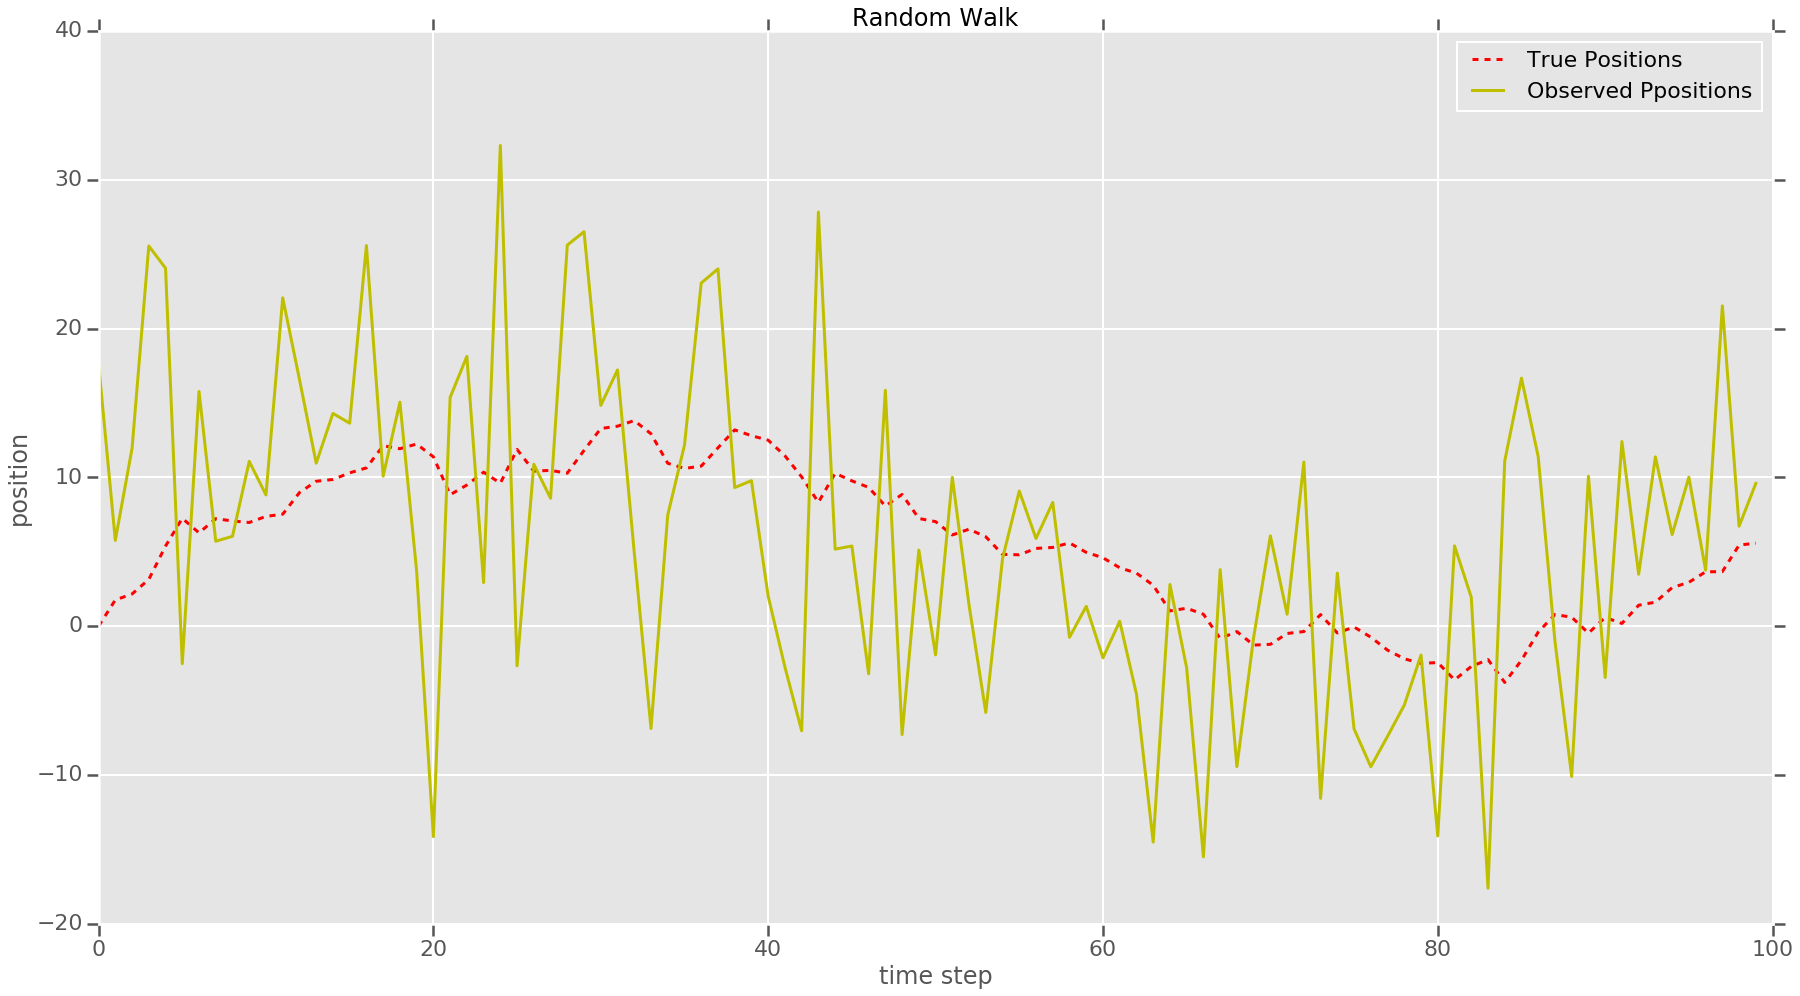

In [4]:
plt.figure(figsize=(30, 16), dpi=100)
plt.plot(true_position, 'r--', label='True Positions')
plt.plot(observed_position, 'y', label='Observed Ppositions')
plt.title('Random Walk')
plt.xlabel('time step')
plt.ylabel('position')
plt.legend(loc='best')


### True Positionsがランダムウォークの真の値$x_t$、Observed Positionsがノイズののった観測値$y_t$です。

In [5]:
class Simple_Kalman:

    def __init__(self, observation, start_position, start_deviation, deviation_true, deviation_noise):

        self.obs = observation
        self.n_obs = len(observation)
        self.start_pos = start_position
        self.start_dev = start_deviation
        self.dev_q = deviation_true
        self.dev_r = deviation_noise

        self._fit()


    def _forward(self):

        self.x_prev_ = [self.start_pos]
        self.P_prev_ = [self.start_dev]
        self.K_ = [self.P_prev_[0] / (self.P_prev_[0] + self.dev_r)]
        self.P_ = [self.dev_r * self.P_prev_[0] / (self.P_prev_[0] + self.dev_r)]
        self.x_ = [self.x_prev_[0] + self.K_[0] * (self.obs[0] - self.x_prev_[0])]

        for t in range(1, self.n_obs):
            self.x_prev_.append(self.x_[t-1])
            self.P_prev_.append(self.P_[t-1] + self.dev_q)

            self.K_.append(self.P_prev_[t] / (self.P_prev_[t] + self.dev_r))
            self.x_.append(self.x_prev_[t] + self.K_[t] * (self.obs[t] - self.x_prev_[t]))
            self.P_.append(self.dev_r * self.P_prev_[t] / (self.P_prev_[t] + self.dev_r))


    def _backward(self):

        self.x_all_ = [self.x_[-1]]
        self.P_all_ = [self.P_[-1]]
        self.C_ = [self.P_[-1] / (self.P_[-1] + self.dev_q)]

        for t in range(2, self.n_obs + 1):
            self.C_.append(self.P_[-t] / (self.P_[-t] + self.dev_q))
            self.x_all_.append(self.x_[-t] + self.C_[-1] * (self.x_all_[-1] - self.x_prev_[-t+1]))
            self.P_all_.append(self.P_[-t] + (self.C_[-1]**2) * (self.P_all_[-1] - self.P_prev_[-t+1]))

        self.C_.reverse()
        self.x_all_.reverse()
        self.P_all_.reverse()


    def _fit(self):
        self._forward()
        self._backward()

In [6]:
kf = Simple_Kalman(observed_position, start_position=0, start_deviation=1, deviation_true=1, deviation_noise=10)

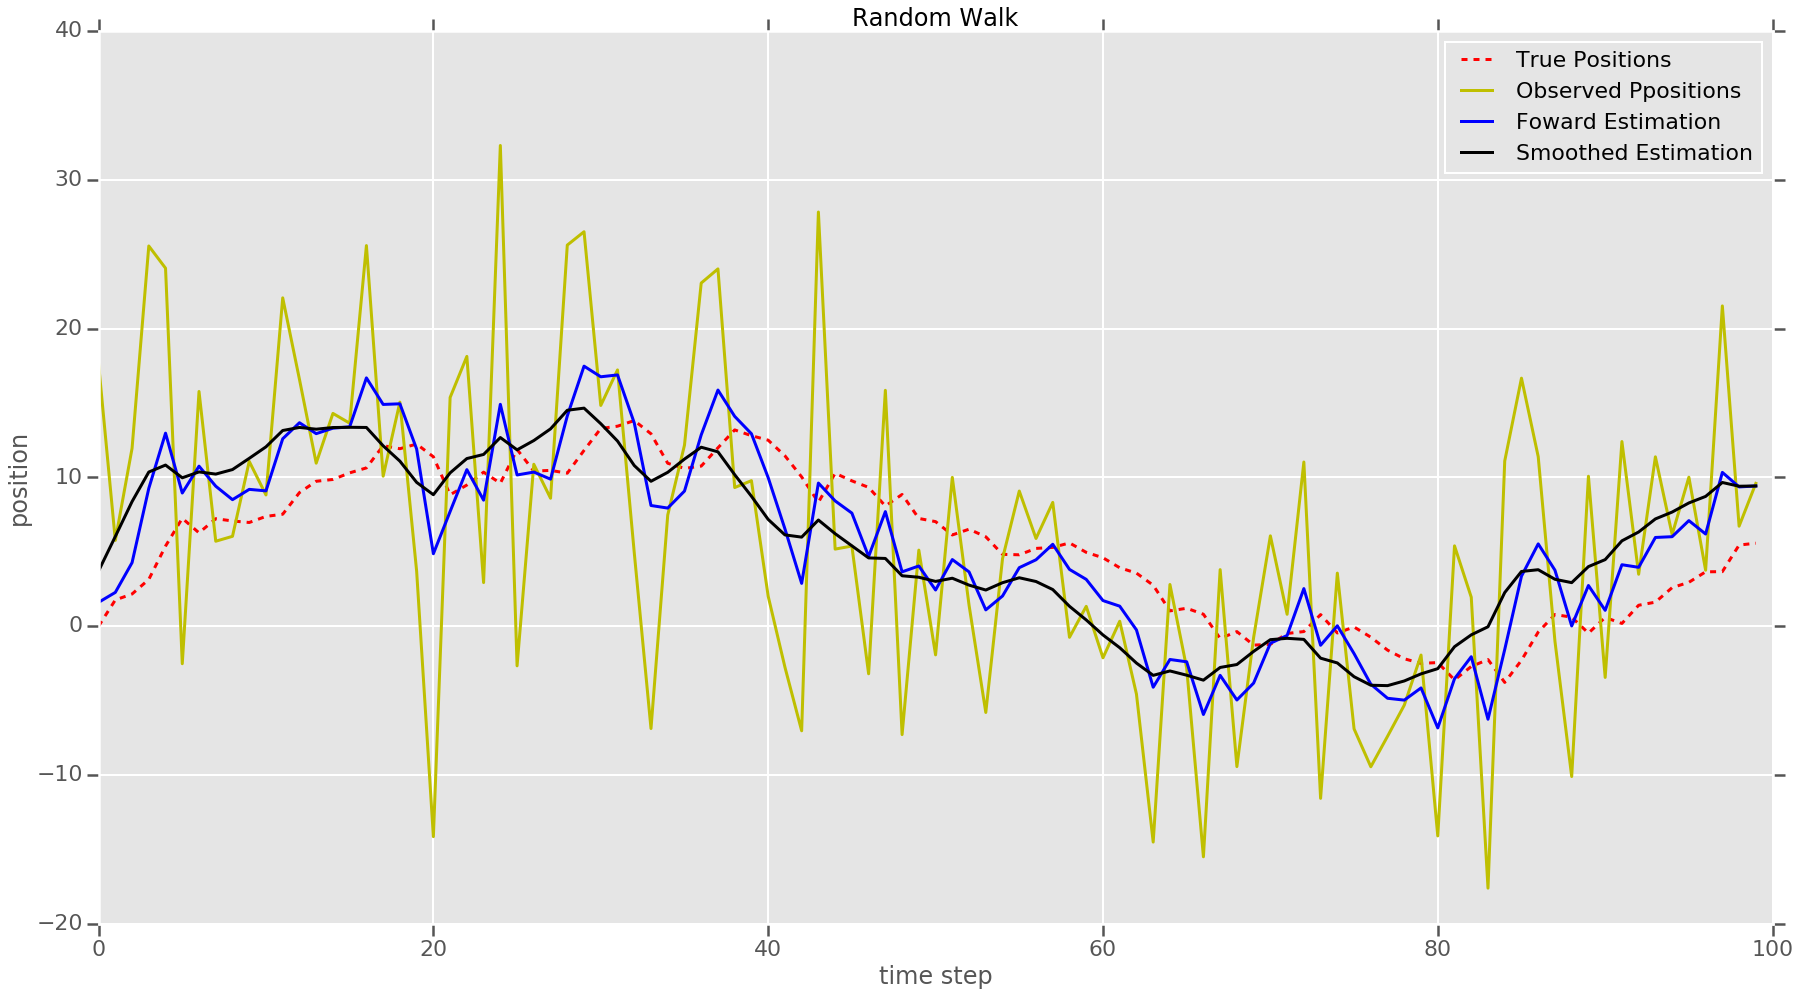

In [7]:
plt.figure(figsize=(30, 16), dpi=100)

plt.plot(true_position, 'r--', label='True Positions')
plt.plot(observed_position, 'y', label='Observed Ppositions')
plt.plot(kf.x_, 'blue' ,label='Foward Estimation')
plt.plot(kf.x_all_, 'black', label='Smoothed Estimation')
plt.title('Random Walk')
plt.xlabel('time step')
plt.ylabel('position')
plt.legend(loc='best')